In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import fashion_mnist
from keras import Sequential
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D
from keras import optimizers, losses
from sklearn.metrics import classification_report
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# В якості згорткової основи скористаємося мережею VGG16, яка була навчена на даних ImageNet
# Імпортуємо модель, щоб створити основу згортки на базі VGG16
conv_vgg16_base = VGG16(include_top=False, input_shape=(32, 32, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [4]:

#  Розширюємо модель, додавши кастомні повнозвʼязні шари
# Для того, щоб модель адекватно навчалась на даному датасеті
conv_vgg16_base.trainable = False

model = Sequential([
   conv_vgg16_base,

   Flatten(),
   Dense(512, activation='relu'),
   Dropout(0.1),
   Dense(10, activation="softmax"),
])

In [5]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14982474 (57.15 MB)
Trainable params: 267786 (1.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [6]:
# Завантажуємо датасет і подивимось на його вміст
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train.shape, x_test.shape, y_train.shape, y_test.shape

4422102/4422102 [==============================] - 1s 0us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

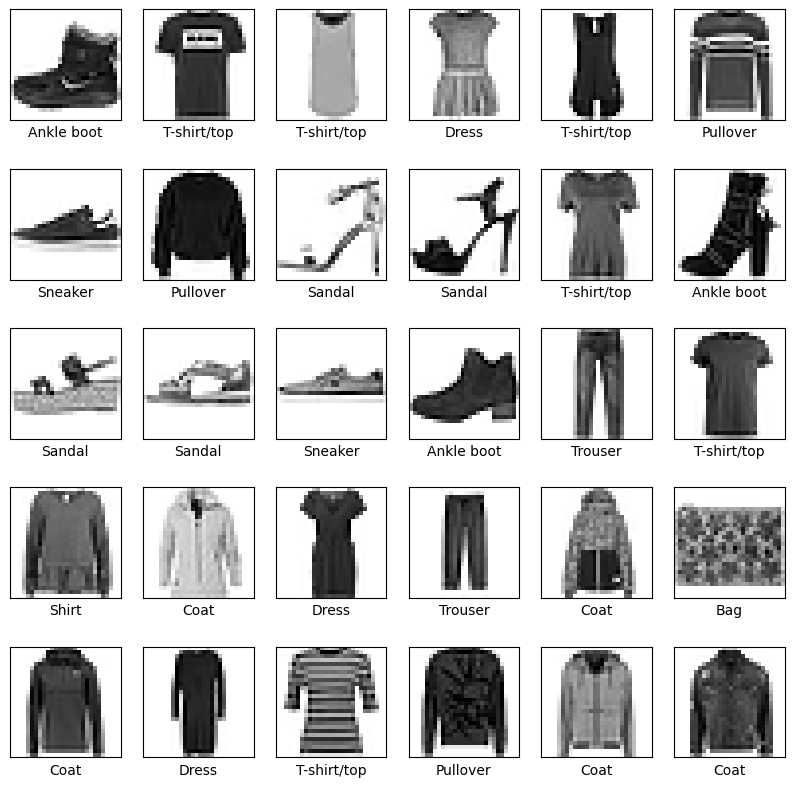

In [7]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Подивимось на перші 30 зображень з тренувальної вибірки, щоб впевнитись що дані в правильному форматі
plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

Дана попередньонавчена згорткова VGG16 модель по-нормальному повинна приймати зображення у форматі 150x150 або 224x224 пікселів. Але по ресурсам памʼяті ми не можемо перевести у розмір 150х150. Мінімальний формат, який приймає наша VGG16 це 32х32х3. Для цього переведемо наш формат 28х28х1 на 32х32х3 як ми задали параметр вхідного формату при імпорті даної моделі. Також потрібно змінити зображення з одного кольорового каналу (чорно-білі) на три кольорові канали:

In [8]:


train_images_rgb = np.repeat(x_train[..., np.newaxis], 3, axis=3)
test_images_rgb = np.repeat(x_test[..., np.newaxis], 3, axis=3)


train_images = np.array([np.resize(img, (32, 32, 3)) for img in train_images_rgb])
test_images = np.array([np.resize(img, (32, 32, 3)) for img in test_images_rgb])


# Робимо скейлінг даних
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255


# Навчання моделі на тренувальній вибірці
history = model.fit(train_images, y_train, epochs=40, batch_size=128, validation_split=0.2)



Epoch 1/40
375/375 [==============================] - 15s 25ms/step - loss: 1.3311 - accuracy: 0.5566 - val_loss: 0.9942 - val_accuracy: 0.6678
Epoch 2/40
375/375 [==============================] - 8s 22ms/step - loss: 0.9232 - accuracy: 0.6867 - val_loss: 0.8565 - val_accuracy: 0.7045
Epoch 3/40
375/375 [==============================] - 8s 22ms/step - loss: 0.8267 - accuracy: 0.7176 - val_loss: 0.7855 - val_accuracy: 0.7293
Epoch 4/40
375/375 [==============================] - 8s 22ms/step - loss: 0.7730 - accuracy: 0.7339 - val_loss: 0.7452 - val_accuracy: 0.7416
Epoch 5/40
375/375 [==============================] - 7s 19ms/step - loss: 0.7368 - accuracy: 0.7455 - val_loss: 0.7141 - val_accuracy: 0.7455
Epoch 6/40
375/375 [==============================] - 7s 20ms/step - loss: 0.7085 - accuracy: 0.7521 - val_loss: 0.6971 - val_accuracy: 0.7547
Epoch 7/40
375/375 [==============================] - 7s 19ms/step - loss: 0.6885 - accuracy: 0.7579 - val_loss: 0.6762 - val_accuracy: 0.761

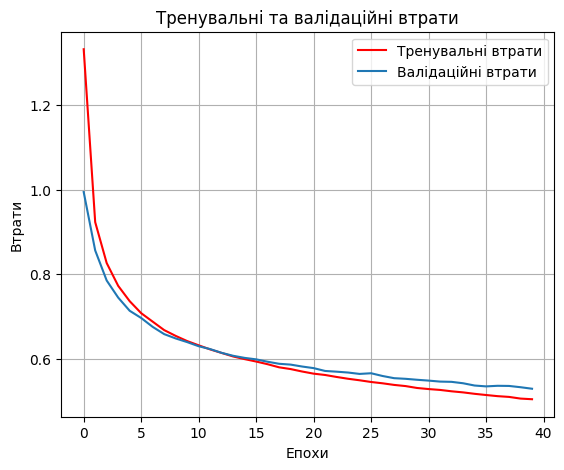

In [9]:
# Візуалізація отриманих даних
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Тренувальні втрати', color='red')
plt.plot(history.history['val_loss'], label='Валідаційні втрати')
plt.title('Тренувальні та валідаційні втрати')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.grid(True)
plt.legend()


plt.show()

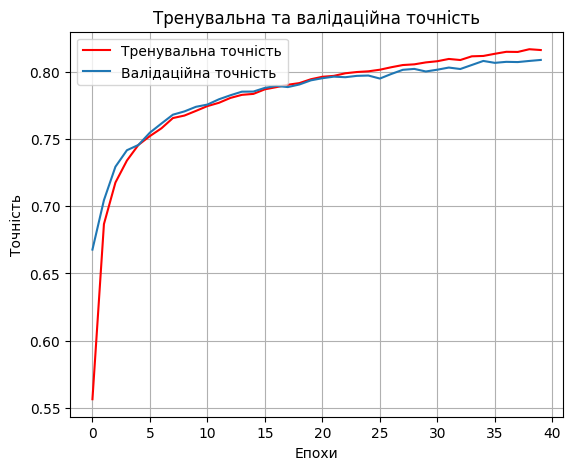

In [10]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Тренувальна точність', color='red')
plt.plot(history.history['val_accuracy'], label='Валідаційна точність')
plt.title('Тренувальна та валідаційна точність')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.grid(True)
plt.legend()

plt.show()



Отже, 82% тренувальна точність та 81% валідаційна точність є доволі не поганим результатом, але не найкращим. Можливо потрібно вказати більше епох.

Також можна покращувати модель застосувавши аугментацію для тренувальних даних, так як аугментація створює більш різноманітний тренувальний набір.


In [11]:
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator()


# Використовуємо .flow() метод для створення генераторів
train_generator = train_datagen.flow(
        train_images,
        y_train,
        batch_size=128)

validation_generator = test_datagen.flow(
        test_images,
        y_test,
        batch_size=128)


# Навчання моделі з використанням генераторів, які задали вище
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_images) // 256,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(test_images) // 256
)



Epoch 1/50
234/234 [==============================] - 26s 107ms/step - loss: 0.9167 - accuracy: 0.6727 - val_loss: 0.7499 - val_accuracy: 0.7388
Epoch 2/50
234/234 [==============================] - 24s 105ms/step - loss: 0.8109 - accuracy: 0.7086 - val_loss: 0.7539 - val_accuracy: 0.7352
Epoch 3/50
234/234 [==============================] - 22s 96ms/step - loss: 0.7899 - accuracy: 0.7143 - val_loss: 0.7544 - val_accuracy: 0.7298
Epoch 4/50
234/234 [==============================] - 22s 94ms/step - loss: 0.7699 - accuracy: 0.7222 - val_loss: 0.7395 - val_accuracy: 0.7400
Epoch 5/50
234/234 [==============================] - 23s 98ms/step - loss: 0.7602 - accuracy: 0.7239 - val_loss: 0.7593 - val_accuracy: 0.7300
Epoch 6/50
234/234 [==============================] - 22s 93ms/step - loss: 0.7600 - accuracy: 0.7227 - val_loss: 0.7503 - val_accuracy: 0.7300
Epoch 7/50
234/234 [==============================] - 24s 102ms/step - loss: 0.7523 - accuracy: 0.7303 - val_loss: 0.7626 - val_accura

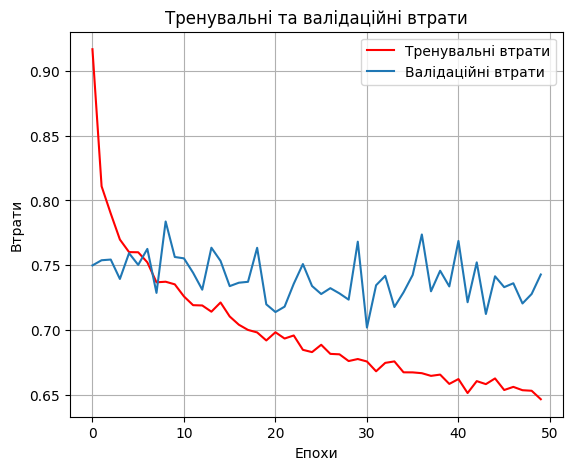

In [12]:
# Візуалізація отриманих даних
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Тренувальні втрати', color='red')
plt.plot(history.history['val_loss'], label='Валідаційні втрати')
plt.title('Тренувальні та валідаційні втрати')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.grid(True)
plt.legend()


plt.show()

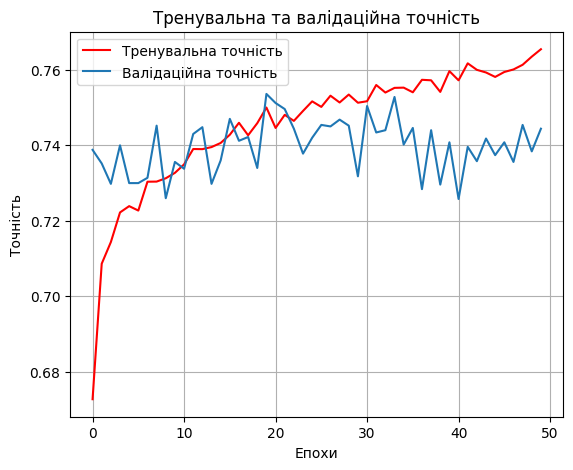

In [13]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Тренувальна точність', color='red')
plt.plot(history.history['val_accuracy'], label='Валідаційна точність')
plt.title('Тренувальна та валідаційна точність')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.grid(True)
plt.legend()

plt.show()



Можна зробити висновок, що дана модель перенавчилась. Точність на тренувальній вибірці стала гіршою - 77%. А отже, аугментація не допомогла покращити дану модель.

Спробуємо донавчити модель, розморозивши частину частину згорткової основи, а саме останні 4 згорткових шари моделі VGG16.


In [14]:


conv_vgg16_base = VGG16(include_top=False, input_shape=(32, 32, 3))


for layer in conv_vgg16_base.layers[:-4]:
    layer.trainable = False
for layer in conv_vgg16_base.layers[-4:]:
    layer.trainable = True



model = Sequential([
   conv_vgg16_base,

   Flatten(),
   Dense(512, activation='relu'),
   Dropout(0.2),
   Dense(10, activation="softmax"),
])


model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14982474 (57.15 MB)
Trainable params: 7347210 (28.03 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [15]:
history = model.fit(train_images, y_train, epochs=40, batch_size=128, validation_split=0.2)

Epoch 1/40
375/375 [==============================] - 14s 30ms/step - loss: 1.0790 - accuracy: 0.6219 - val_loss: 0.6687 - val_accuracy: 0.7607
Epoch 2/40
375/375 [==============================] - 11s 29ms/step - loss: 0.6400 - accuracy: 0.7718 - val_loss: 0.5776 - val_accuracy: 0.7904
Epoch 3/40
375/375 [==============================] - 11s 29ms/step - loss: 0.5557 - accuracy: 0.7984 - val_loss: 0.5135 - val_accuracy: 0.8146
Epoch 4/40
375/375 [==============================] - 12s 33ms/step - loss: 0.5127 - accuracy: 0.8149 - val_loss: 0.4882 - val_accuracy: 0.8227
Epoch 5/40
375/375 [==============================] - 12s 32ms/step - loss: 0.4835 - accuracy: 0.8260 - val_loss: 0.4733 - val_accuracy: 0.8280
Epoch 6/40
375/375 [==============================] - 12s 33ms/step - loss: 0.4591 - accuracy: 0.8334 - val_loss: 0.4513 - val_accuracy: 0.8382
Epoch 7/40
375/375 [==============================] - 11s 29ms/step - loss: 0.4458 - accuracy: 0.8384 - val_loss: 0.4403 - val_accuracy:

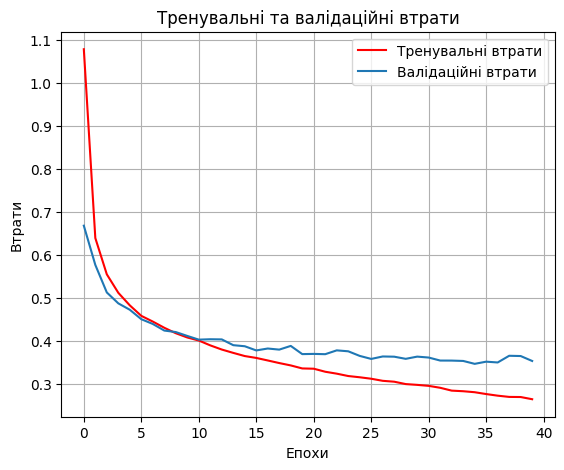

In [16]:
# Візуалізація отриманих даних
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Тренувальні втрати', color='red')
plt.plot(history.history['val_loss'], label='Валідаційні втрати')
plt.title('Тренувальні та валідаційні втрати')
plt.xlabel('Епохи')
plt.ylabel('Втрати')
plt.grid(True)
plt.legend()


plt.show()

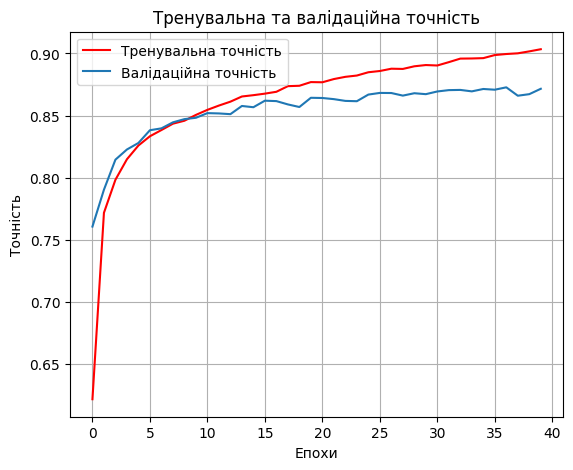

In [17]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Тренувальна точність', color='red')
plt.plot(history.history['val_accuracy'], label='Валідаційна точність')
plt.title('Тренувальна та валідаційна точність')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.grid(True)
plt.legend()

plt.show()



Як бачимо, що при донавчанні мережа показала кращі результати, а саме 90% точності. Тому можна зробити висновок, що саме донавчання виявилось найкращим варіантом для роботи з датасетом fashion_mnist через згорткову нейронну мережу VGG16.

Оцінимо модель.

Перед тим, як оцінити модель на тестовій вибірці, перетворимо її у розмір зображень 32х32х3.


In [18]:


x_test_resized = np.array([np.resize(img, (32, 32)) for img in x_test])
x_test_rgb = np.repeat(x_test_resized[..., np.newaxis], 3, axis=-1)


# # Нормалізуємо дані
x_test_rgb = x_test_rgb.astype('float32') / 255.


# Оцінка моделі на тестовій вибірці
test_loss, test_accuracy = model.evaluate(x_test_rgb, y_test, verbose=2)

print(f"Тестова втрата: {test_loss}")
print(f"Тестова точність: {test_accuracy}")



313/313 - 5s - loss: 0.3638 - accuracy: 0.8698 - 5s/epoch - 15ms/step
Тестова втрата: 0.36379769444465637
Тестова точність: 0.8697999715805054




Отже, в даному ДЗ було використано попередньо навчену модель VGG16. Завантаживщи дану згорткову нейронну мережу, було додано Flatten та 2 Dense шари. Отримано точність - 82%.

Далі зробивши аугментацію даних, на виході отримали гірший результат - 77% та перенавчання на валідаційних даних.

Потім було реалізовано донавчання, використувавши VGG16 розморозивши 4 останніх шари, отримавши точність 90%.

Після проведення оцінки моделі на тестовому датасеті отримано точність 87% та тестову втрату 0,36.
